# Session 1: Machine Learning Fundamentals & Model Evaluation

**Optional**: create a local virtual environment and register a Jupyter kernel

If you don't have a virtual environment for this project, run the cell below to create `.venv`, install common ML packages, and register a kernel named `ml-self-study`.  Skip this cell if you already have an environment.

In [1]:
# %%bash

# if [ -d ".venv" ]; then 
#     echo ".venv already exists, skipping creation" 
# else 
#     python -m venv .venv 
#     . .venv/bin/activate 
#     pip install -U pip 
#     pip install ipykernel scikit-learn matplotlib numpy pandas seaborn joblib jupyterlab notebook 
#     python -m ipykernel install --user --name ml-self-study --display-name "Python (ml-self-study)"
#     echo "Installed kernel: Python (ml-self-study)"
# fi


# Learning Curves — practice with scikit-learn

This notebook reproduces the scikit-learn 'plot_learning_curve' example from  https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html and provides hands-on exercises. Objectives:
- Reproduce the learning-curve plot for a classifier.
- Interpret the learning curve (bias vs variance).
- Try different models, preprocessing, and datasets.

In [2]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.datasets import load_digits, fetch_california_housing
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## What `learning_curve` computes (high-level)

The `learning_curve` helper measures model performance as the training set size grows. For each value in `train_sizes` it:

1. Repeats a cross-validation loop (using the `cv` splitter you provide).
2. For every CV split:
   - Selects a subset of the training fold with the requested number of training examples,
   - Fits the estimator on that subset,
   - Computes the score on the training subset (training score) and on the validation fold (validation score).
3. Aggregates the scores across CV splits and returns arrays: `train_sizes`, `train_scores`, `test_scores`.

Plotting the mean ± std of the training and cross-validation scores vs. training size helps diagnose:
- High bias — both training and validation scores are low and close together.
- High variance — training score is high but validation score is much lower.

Simple illustrative code for what `learning_curve` is doing under the hood:

```python
import numpy as np
from sklearn.model_selection import ShuffleSplit

def manual_learning_curve(estimator, X, y, train_sizes, cv):
    train_scores = []
    test_scores = []
    for n in train_sizes:
        # n may be a fraction (0.1..1.0) or an absolute count
        n_train = int(n * len(X)) if 0 < n <= 1 else int(n)
        scores_train_n = []
        scores_test_n = []
        for train_idx, test_idx in cv.split(X, y):
            subset_idx = np.random.choice(train_idx, n_train, replace=False)
            estimator.fit(X[subset_idx], y[subset_idx])
            scores_train_n.append(estimator.score(X[subset_idx], y[subset_idx]))
            scores_test_n.append(estimator.score(X[test_idx], y[test_idx]))
        train_scores.append(scores_train_n)
        test_scores.append(scores_test_n)
    return np.array(train_scores), np.array(test_scores)
```

Tips:
- `train_sizes` accepts fractions (portion of full training data) or absolute counts.
- Wrap preprocessing in a `Pipeline` so transforms occur inside each CV loop.
- Set `n_jobs` to parallelize calls where supported, and pick an appropriate `scoring` for your task.

In [3]:
from sklearn.model_selection import ShuffleSplit
import numpy as np

X = np.arange(20).reshape(10,2)   # 10 samples
X = X * 10
print("The original data:")
print(X, "\n")
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

print("The splits:")
for i, (train_idx, test_idx) in enumerate(cv.split(X)):
    print(i, train_idx.shape[0], test_idx.shape[0])
    # enumerate cv.split(X) to get the train/test indices
    print("train_idx:\n", train_idx)
    print("test_idx:\n", test_idx)
    X_train, X_test = X[train_idx], X[test_idx]
    print("X_train:\n", X_train)
    print("X_test:\n", X_test)


The original data:
[[  0  10]
 [ 20  30]
 [ 40  50]
 [ 60  70]
 [ 80  90]
 [100 110]
 [120 130]
 [140 150]
 [160 170]
 [180 190]] 

The splits:
0 8 2
train_idx:
 [4 9 1 6 7 3 0 5]
test_idx:
 [2 8]
X_train:
 [[ 80  90]
 [180 190]
 [ 20  30]
 [120 130]
 [140 150]
 [ 60  70]
 [  0  10]
 [100 110]]
X_test:
 [[ 40  50]
 [160 170]]
1 8 2
train_idx:
 [1 2 9 8 0 6 7 4]
test_idx:
 [3 5]
X_train:
 [[ 20  30]
 [ 40  50]
 [180 190]
 [160 170]
 [  0  10]
 [120 130]
 [140 150]
 [ 80  90]]
X_test:
 [[ 60  70]
 [100 110]]
2 8 2
train_idx:
 [8 4 5 1 0 6 9 7]
test_idx:
 [2 3]
X_train:
 [[160 170]
 [ 80  90]
 [100 110]
 [ 20  30]
 [  0  10]
 [120 130]
 [180 190]
 [140 150]]
X_test:
 [[40 50]
 [60 70]]
3 8 2
train_idx:
 [9 2 7 5 8 0 3 4]
test_idx:
 [6 1]
X_train:
 [[180 190]
 [ 40  50]
 [140 150]
 [100 110]
 [160 170]
 [  0  10]
 [ 60  70]
 [ 80  90]]
X_test:
 [[120 130]
 [ 20  30]]
4 8 2
train_idx:
 [7 4 1 0 6 8 9 3]
test_idx:
 [5 2]
X_train:
 [[140 150]
 [ 80  90]
 [ 20  30]
 [  0  10]
 [120 130]
 [160 

In [4]:
# Utility: plot_learning_curve function (compatible with scikit-learn's example)
import warnings
warnings.filterwarnings('ignore')

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None,
                        train_sizes=np.linspace(0.1, 1.0, 5), ylim=None):
    """
    Generate a simple plot of the test and training learning curve.
    Returns the matplotlib figure object.
    """
    plt.figure(figsize=(8, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.legend(loc='best')
    plt.tight_layout()
    return plt

## Learning curve evaluation on the Digits dataset

Dataset — `digits`

- The `digits` dataset contains 1,797 images of handwritten digits. Each image is 8×8 pixels and is represented as a 64-dimensional feature vector (pixel intensities). The target is an integer label 0–9 (10 classes). For more information see https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits

Key components used in this example:

- `ShuffleSplit` — a cross-validator that generates repeated randomized train/test splits. For each split it shuffles indices and returns train/test indices; useful for estimating performance variability (used here for the repeated splits in the learning curve).

- `SVC` — Support Vector Classifier (SVM). A margin-based classifier that can use different kernels (RBF, linear, polynomial). Important hyperparameters include `C` (regularization strength) and `gamma` (kernel width for RBF). When applied to raw pixel features SVMs often benefit from scaling.  For more information see https://www.geeksforgeeks.org/machine-learning/introduction-to-support-vector-machines-svm/

- `make_pipeline` — a small utility that chains preprocessing steps and an estimator (e.g., `StandardScaler` then `SVC`) into a single estimator. Using a pipeline ensures preprocessing happens inside each cross-validation fold, avoiding data leakage and simplifying use with `learning_curve` and other scikit-learn helpers.

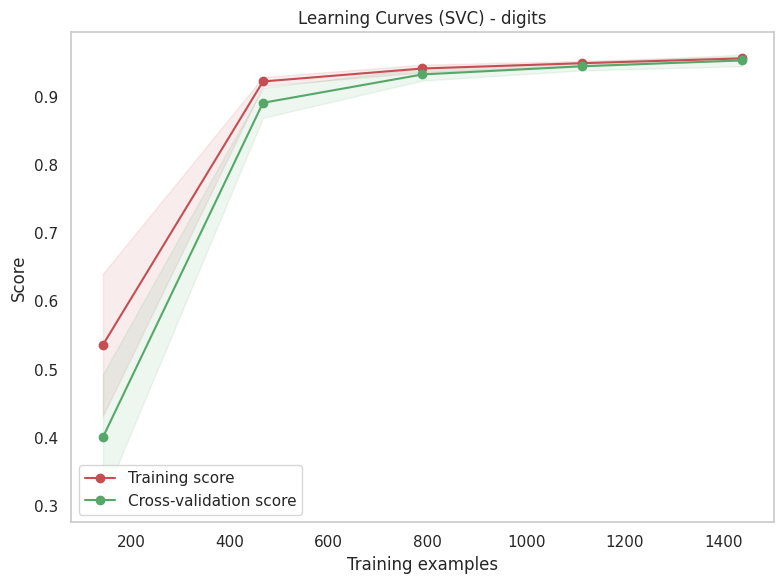

In [5]:
# Example 1: digits dataset + SVC (with a scaler in a pipeline)
from sklearn.datasets import load_digits
from sklearn.model_selection import ShuffleSplit

data = load_digits()
X, y = data.data, data.target
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = make_pipeline(StandardScaler(), SVC(gamma=0.001))
plot_learning_curve(estimator, 'Learning Curves (SVC) - digits', X, y, cv=cv, n_jobs=1)
plt.show()

## Learning curves using a different estimator.

Random forests consist of an ensemble of decision trees trained on random subsets of the training data. Before the deep learning revolution they were considered the SOTA for training on large datasets. https://www.statology.org/random-forests/

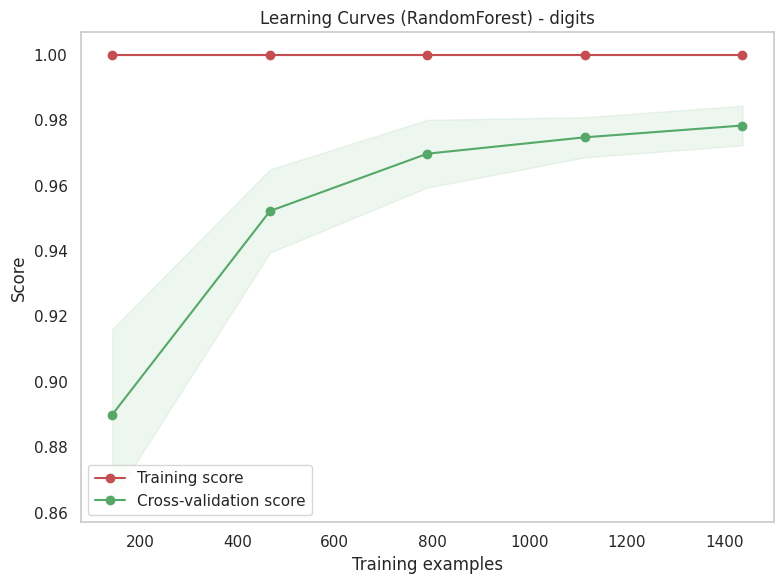

In [6]:
# Example 2: RandomForest on the same dataset (no scaler required)
estimator_rf = RandomForestClassifier(n_estimators=100, random_state=0)
plot_learning_curve(estimator_rf, 'Learning Curves (RandomForest) - digits', X, y, cv=cv, n_jobs=1)
plt.show()

## Learning Curve Exercises

- Try different estimators (LogisticRegression, SVC with different kernels, RandomForest, GradientBoosting, MLP). Which yields the best performance? 
- Tip: add a preprocessing step (StandardScaler) when using SVM or MLP.
- Change the `train_sizes` grid and see how the curve behaves for small/large training sets.
- Compare models on different datasets: `iris`, `wine`, `breast_cancer`, `fetch_california_housing` (regression).
- Interpret the curves: identify signs of high bias and/or high variance and suggest fixes.



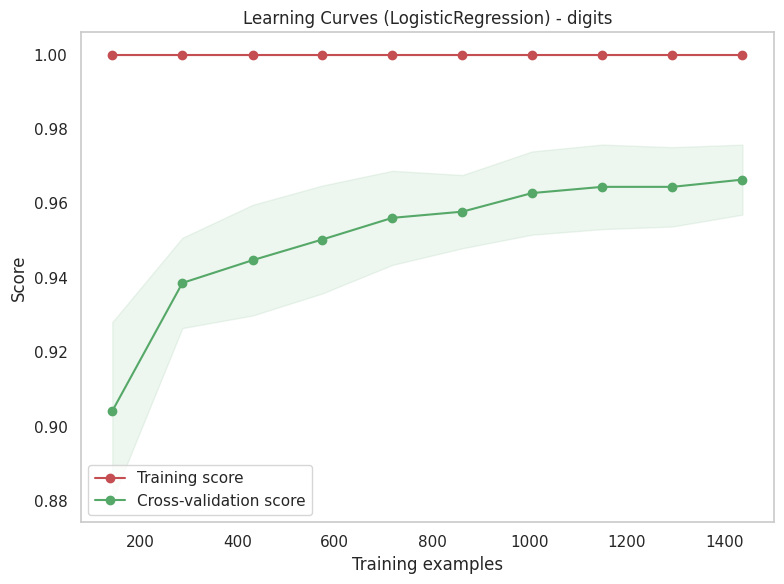

In [7]:
# LogisticRegression exercise on the same dataset, using smaller 10% steps
estimator_lr = LogisticRegression(random_state=0)
plot_learning_curve(estimator_lr, 'Learning Curves (LogisticRegression) - digits', X, y, cv=cv, n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 10))
plt.show()

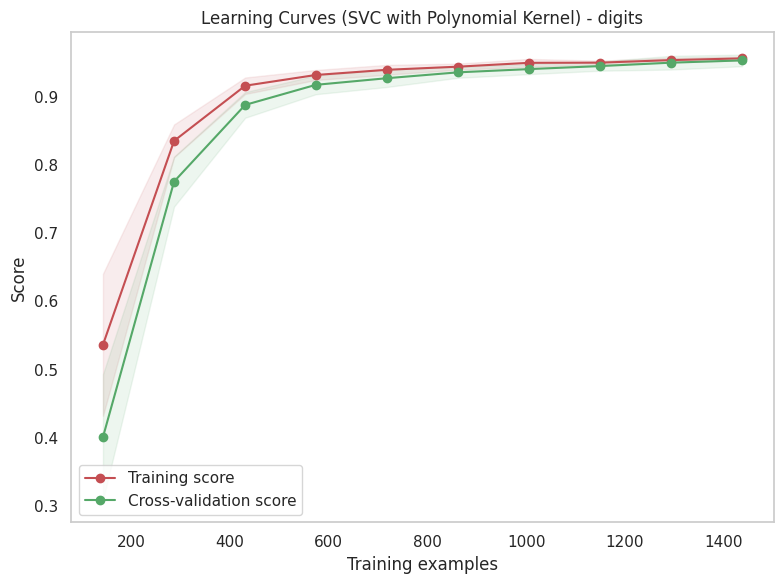

In [8]:
# SVC with different kernel
estimator_svc_poly = make_pipeline(StandardScaler(), SVC(kernel='poly', degree=3, C=1.0, coef0=1.0))
plot_learning_curve(estimator, 'Learning Curves (SVC with Polynomial Kernel) - digits', X, y, cv=cv, n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 10))
plt.show()

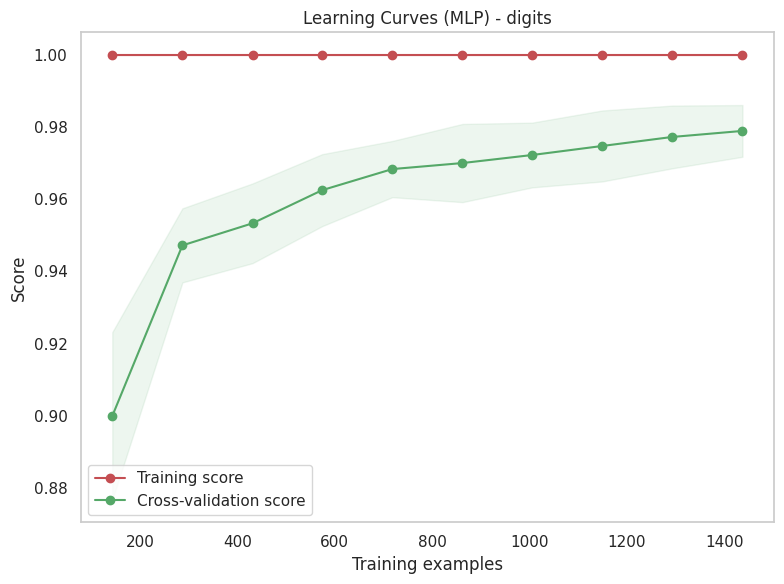

In [9]:
# MLP
from sklearn.neural_network import MLPClassifier


estimator_mlp = make_pipeline(StandardScaler(), MLPClassifier(random_state=0))
plot_learning_curve(estimator_mlp, 'Learning Curves (MLP) - digits', X, y, cv=cv, n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 10))
plt.show()

## Evaluation Exercise: Generating binary classification predictions and interpreting metrics

The `breast_cancer` dataset consists of a binary classification problem predicting target variable y=0: malignant or y=1: benign. Using an 80:20 `sklearn.model_selection.train_test_split` and `sklearn.ensemble.RandomForestClassifier` train a predictor on the training set. Use `estimator.predict` to make predictions on the test set, and then plot the receiver-operator characteristic (ROC) curve using `sklearn.metrics.roc_curve`.  What does this curve tell you about the quality of the estimator? Feel free to refer to online resources to learn more about these methods.

Test accuracy: 0.9473684210526315
ROC AUC: 0.973
Best threshold by Youden's J statistic: 0.48


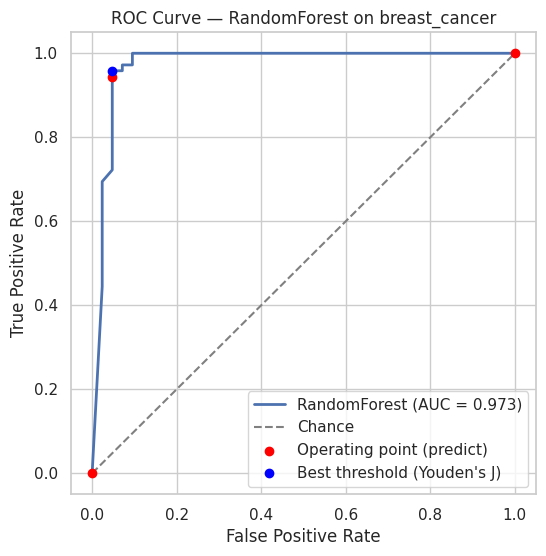

Interpretation: A ROC AUC near 1.0 indicates strong separability between classes
by the model. The plotted ROC curve bowing towards the top-left and a high AUC
here imply the RandomForest is performing well on this test split. The red
operating point shows the single sensitivity/specificity obtained if you use
the discrete predict() labels — ROC using continuous scores provides a fuller
picture of trade-offs across thresholds.


In [15]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, ConfusionMatrixDisplay

# Train / evaluate a RandomForest on the breast_cancer dataset and plot ROC


# Load data
bc = load_breast_cancer()
X_bc, y_bc = bc.data, bc.target  # y: 0 = malignant, 1 = benign

# 80:20 train/test split (stratify to keep class proportions)
X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(
  X_bc, y_bc, test_size=0.2, random_state=0, stratify=y_bc
)

estimator_rf = RandomForestClassifier(n_estimators=100, random_state=0)
estimator_rf.fit(X_train_bc, y_train_bc)

# Make discrete predictions as requested
y_pred = estimator_rf.predict(X_test_bc)
# print("Predictions:", y_pred)
print("Test accuracy:", accuracy_score(y_test_bc, y_pred))

# For ROC we need continuous scores; use predict_proba for the positive class
y_score = estimator_rf.predict_proba(X_test_bc)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_bc, y_score)
auc = roc_auc_score(y_test_bc, y_score)
print(f"ROC AUC: {auc:.3f}")

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'RandomForest (AUC = {auc:.3f})', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')
# Also show the ROC point corresponding to the hard predictions (single operating point)
fpr_pt, tpr_pt, _ = roc_curve(y_test_bc, y_pred)
# roc_curve returns multiple points for discrete scores; pick the one corresponding to threshold=0.5-like:
# Plot the operating point(s) from discrete predictions
plt.scatter(fpr_pt, tpr_pt, color='red', zorder=2, label='Operating point (predict)')
fpr, tpr, thr = roc_curve(y_test_bc, y_score)
j = tpr - fpr
best_idx = np.argmax(j)
best_threshold = thr[best_idx]
print("Best threshold by Youden's J statistic:", best_threshold)

# Plot best threshold point
best_fpr = fpr[best_idx]
best_tpr = tpr[best_idx]
plt.scatter(best_fpr, best_tpr, color='blue', zorder=2, label="Best threshold (Youden's J)")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — RandomForest on breast_cancer')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Quick interpretation (concise)
print(
  "Interpretation: A ROC AUC near 1.0 indicates strong separability between classes\n"
  "by the model. The plotted ROC curve bowing towards the top-left and a high AUC\n"
  "here imply the RandomForest is performing well on this test split. The red\n"
  "operating point shows the single sensitivity/specificity obtained if you use\n"
  "the discrete predict() labels — ROC using continuous scores provides a fuller\n"
  "picture of trade-offs across thresholds."
)

## Supplemental material

### Regression example: learning curve for a regressor using California housing

**Warning**: the example below may take several minutes to run to completion.

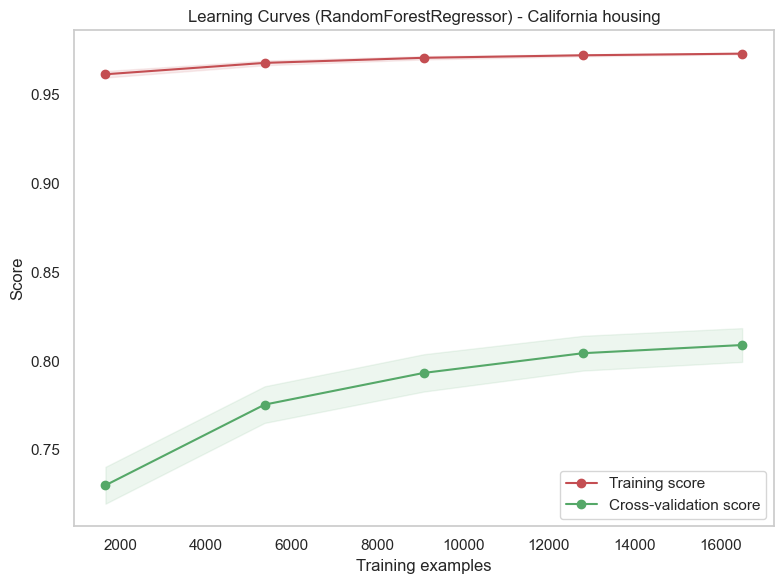

In [ ]:

from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
Xh = housing.data
yh = housing.target

est_reg = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=0))
plot_learning_curve(est_reg, 'Learning Curves (RandomForestRegressor) - California housing', Xh, yh, cv=cv, n_jobs=1)
plt.show()

### Suggestions

These suggestions complement the hands-on exercises above — try other combinations of models, datasets, and evaluation protocols.

- Other models to try: LogisticRegression, SVC, RandomForest, HistGradientBoosting, optionally XGBoost / LightGBM, MLP, KNN.
- Datasets to explore: `iris`, `wine`, `diabetes`, `fetch_california_housing`, and larger UCI/Kaggle datasets for scaling experiments.
- Useful extensions: use validation curves to probe hyperparameters; wrap preprocessing + estimator in a `Pipeline` and run `GridSearchCV` or `RandomizedSearchCV`; use stratified CV and task-appropriate metrics (e.g., `f1`, `roc_auc`) for imbalanced problems.

